In [1]:
try:
    import warnings
    warnings.filterwarnings('ignore')
    import utils
except Exception as e:
    print(e)
    from tensorflow.keras.applications.vgg16 import preprocess_input
    def preprocess_img(x):
        return preprocess_input(x, mode='tf')
    pass

No module named 'utils'


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet101
from keras_applications.resnext import ResNeXt101,ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model, Sequential, Input
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import PIL
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [3]:
path_data = '../garbage_classify/train_data'
batch_size = 32
img_width = 224
img_height = 224
img_size = 224
random_seed = 201908
path_data_train = '../tmp/data_train/'
path_data_valid = '../tmp/data_valid/'
labels_file = '../tmp/labels_raw.csv'

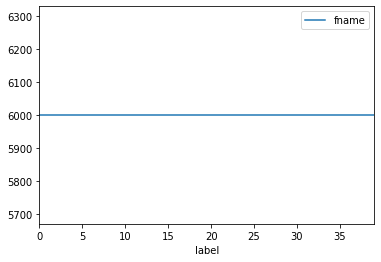

In [4]:
labels_train = pd.read_csv('../tmp/labels_train.csv')
labels_valid = pd.read_csv('../tmp/labels_valid.csv')
n_classess = labels_train.label.unique().shape[0]
n_classess
labels_train.groupby(by='label').count().plot()

In [5]:
labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

Found 240000 validated image filenames belonging to 40 classes.
Found 2978 validated image filenames belonging to 40 classes.


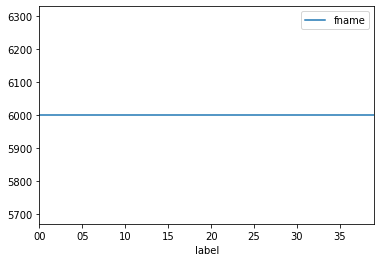

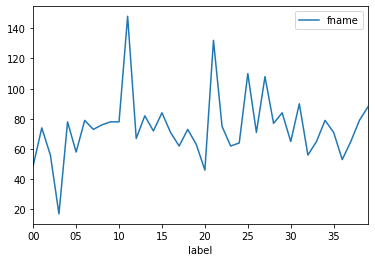

In [6]:
ig = ImageDataGenerator(preprocessing_function=preprocess_img)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    seed=random_seed)

train_g = ig.flow_from_dataframe(
    labels_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(
    labels_valid, path_data_valid, **params_g)
labels_train.groupby(by='label').count().plot()
labels_valid.groupby(by='label').count().plot()


In [7]:
base_model = ResNet101(
    weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3),
    backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)
# base_model = InceptionV3(weights=None, include_top=False)
# base_model = ResNet50(
#     weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# 添加全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)

# 添加一个全连接层
# x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# 添加一个分类器，假设我们有200个类
predictions = Dense(n_classess, activation='softmax')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()
# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 InceptionV3 的卷积层
# for layer in base_model.layers:
#     layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# %%
ckpt = ModelCheckpoint(
    '../tmp/ckpt-exp1-'+time.strftime('%Y-%m-%d_%H_%M')+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc')
estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,
                      verbose=1, patience=20)


In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt, estop],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4926/7500 [==================>...........] - ETA: 15:23 - loss: 0.5585 - acc: 0.8349